# Improvements and modifications of the Stokes solver

We consider the steady Stokes problem with mixed BCs defined in the unit square domain $\Omega := {[0,1]}^2$ by the following set of equations:
$$ 
\begin{cases}
  -\boldsymbol{\Delta} \boldsymbol{u} + \boldsymbol{\nabla} p = 0, 
  \qquad&\text{in }\Omega, \\
  \boldsymbol{\nabla} \cdot \boldsymbol{u} = 0, 
  \qquad &\text{in }\Omega, \\
\boldsymbol{u} = 1\boldsymbol{i} + 0\boldsymbol{j}, \qquad&\text{on }\Gamma^{\text{right}} = \{ x = 1, \, 0\le y\le1 \}, \\
  (\boldsymbol{\nabla}\boldsymbol{u}-p)\cdot\boldsymbol{n} = \boldsymbol{0}, \qquad&\text{on }\Gamma^{\text{left}} = \{ x = 0, \, 0\le y\le1 \},\\
    \boldsymbol{u} = \boldsymbol{0}, \qquad& \text{on } \partial\Omega\setminus(\Gamma^{\text{right}}\cup\Gamma^{\text{left}}).
\end{cases}
$$

The algebraic formulation of the finite element approximation has the following block structure
$$
\begin{bmatrix} A & B^T \\ B & 0\end{bmatrix}
\begin{bmatrix}\boldsymbol{U} \\ \boldsymbol{P}\end{bmatrix}
=
\begin{bmatrix}\boldsymbol{f} \\ \boldsymbol{0}\end{bmatrix}.
$$

We consider different solution of the block system associated to the problem using **the FE stable pair $\mathbb{P}^2-\mathbb{P}^1$**.

In [1]:
%%capture
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from fenics import *

### Method 1: Usual FEniCS approach


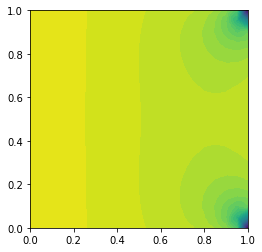

In [ ]:
# 1. mesh generation
n = 20
mesh = UnitSquareMesh(n, n, 'crossed')

# 2. finite element spaces and BCs
V = VectorElement('CG', mesh.ufl_cell(), 2)
Q = FiniteElement('CG', mesh.ufl_cell(), 1)
X = FunctionSpace(mesh, V*Q)

boundary_markers = MeshFunction('size_t', mesh, mesh.geometric_dimension()-1, 0)

class left_boundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0)

class right_boundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 1)

class other_boundary(SubDomain):
    def inside(self, x, on_boundary):
        bottom_top = near(x[1], 0) or near(x[1], 1)
        return on_boundary and bottom_top

left = left_boundary()
left.mark(boundary_markers, 1)
right = right_boundary()
right.mark(boundary_markers, 2)
other = other_boundary()
other.mark(boundary_markers, 3)
    
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

bcs = [DirichletBC(X.sub(0), Constant((1, 0)), boundary_markers, 2),
       DirichletBC(X.sub(0), Constant((0, 0)), boundary_markers, 3)]

# 3. Define variational problem 
u, p = TrialFunctions(X)
v, q = TestFunctions(X)
f = Constant((0, 0))
gN = Constant((0, 0))

a = inner(grad(v), grad(u))*dx -div(v)*p*dx -div(u)*q*dx
L = dot(v, f)*dx + dot(v, gN)*ds(1)

# 4. solution
x = Function(X)
solve(a == L, x, bcs)

u, p = x.split()
plot(p)

### Method 2: Multiphenics package

In [2]:
%%capture
!pip install git+https://github.com/mathLab/multiphenics.git
from multiphenics import *
from numpy import isclose
import matplotlib.pyplot as plt

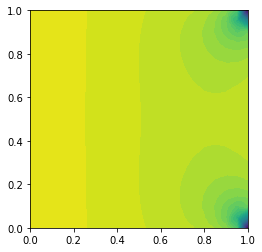

In [4]:
# 1. mesh generation
n = 20
mesh = UnitSquareMesh(n, n, 'crossed')

# 2. finite element spaces and BCs
V = VectorFunctionSpace(mesh, 'CG', 2)
Q = FunctionSpace(mesh, 'CG', 1)
X = BlockFunctionSpace([V, Q])

boundary_markers = MeshFunction('size_t', mesh, mesh.geometric_dimension()-1, 0)

class left_boundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0)

class right_boundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 1)

class other_boundary(SubDomain):
    def inside(self, x, on_boundary):
        bottom_top = near(x[1], 0) or near(x[1], 1)
        return on_boundary and bottom_top

left = left_boundary()
left.mark(boundary_markers, 1)
right = right_boundary()
right.mark(boundary_markers, 2)
other = other_boundary()
other.mark(boundary_markers, 3)
    
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

bcu = [DirichletBC(X.sub(0), Constant((1, 0)), boundary_markers, 2),
       DirichletBC(X.sub(0), Constant((0, 0)), boundary_markers, 3)]

bcs = BlockDirichletBC([bcu, []])

# 3. Define variational problem 
up = BlockTrialFunction(X)
vq = BlockTestFunction(X)
(u, p) = block_split(up)
(v, q) = block_split(vq)

# Create the block matrix for the LHS
aa = [[inner(grad(v), grad(u))*dx, -div(v)*p*dx],
      [-div(u)*q*dx, 0                         ]]
AA = block_assemble(aa)
bcs.apply(AA)
    
# Create the block vector for the RHS
f = Constant((0, 0))
gN = Constant((0, 0))
ff = [dot(v, f)*dx + dot(v, gN)*ds(1), Constant(0) * q * dx]
FF = block_assemble(ff)
bcs.apply(FF)

# 4. Solve linear system
UP = BlockFunction(X)
block_solve(AA, UP.block_vector(), FF)
U, P = UP
plot(P)

### Method 3: Scipy algebraic sparse solvers

In [5]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import inv, spsolve

In [7]:
# 1. mesh generation
n = 20
mesh = UnitSquareMesh(n, n, 'crossed')

# 2. finite element spaces and BCs
V = VectorFunctionSpace(mesh, 'CG', 2)
Q = FunctionSpace(mesh, 'CG', 1)

boundary_markers = MeshFunction('size_t', mesh, mesh.geometric_dimension()-1, 0)

class left_boundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0)

class right_boundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 1)

class other_boundary(SubDomain):
    def inside(self, x, on_boundary):
        bottom_top = near(x[1], 0) or near(x[1], 1)
        return on_boundary and bottom_top

left = left_boundary()
left.mark(boundary_markers, 1)
right = right_boundary()
right.mark(boundary_markers, 2)
other = other_boundary()
other.mark(boundary_markers, 3)
    
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

bcs = [DirichletBC(V, Constant((1, 0)), boundary_markers, 2),
       DirichletBC(V, Constant((0, 0)), boundary_markers, 3)]

# 3. block assembly
u, p = TrialFunction(V), TrialFunction(Q)
v, q = TestFunction(V), TestFunction(Q)

f = Constant((0, 0))
gN = Constant((0, 0))

a = inner(grad(u), grad(v)) * dx
bT = -div(v) * p * dx
b = -div(u) * q * dx
L1 = dot(f, v) * dx + dot(gN, v) * ds
L2 = Constant(0)* q * dx

A, f1 = assemble_system(a, L1)
BT = assemble(bT)
B = assemble(b)
f2 = assemble(L2)
for bc in bcs:
    bc.apply(A, f1)
    bc.zero(BT)

In [8]:
#4a. check sizes of matrices
size_A = A.array().shape
size_B = B.array().shape
size_BT = BT.array().shape
print(size_A, size_B, size_BT)

#4b. assemble block linear system
nnkns = A.array().shape[0] + B.array().shape[0]
AA = np.zeros((nnkns, nnkns))
AA[0:A.array().shape[0], 0:A.array().shape[0]] = A.array()[:,:]
AA[0:A.array().shape[0], A.array().shape[0]:nnkns] = BT.array()[:,:]
AA[A.array().shape[0]:nnkns, 0:A.array().shape[0]] = B.array()[:,:]

ff = np.zeros(nnkns)
ff[0:f1.get_local().size] = f1.get_local()[:]
ff[f1.get_local().size:nnkns] = f2.get_local()[:]

#4c. solve linear system
AA_sp = sp.csr_matrix(AA)
xx = spsolve(AA_sp, ff, use_umfpack=True) 
print("Error: %s" % (AA_sp * xx - ff))  

(6562, 6562) (841, 6562) (6562, 841)
Error: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.33680869e-19
 -4.03073863e-18 -8.89649292e-20]


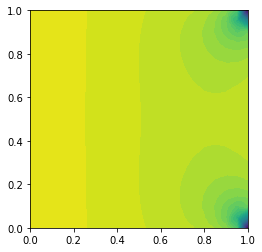

In [9]:
#5. Postprocess solutions
u = Function(V)
u.vector().set_local(xx[0:A.array().shape[0]])

p = Function(Q)
p.vector().set_local(xx[A.array().shape[0]:nnkns])
plot(p)

### Method 4: Shur complement with scipy

Performing a block Gaussian elimination the previous system can be reduced to the equation
$$
            S \boldsymbol{P} = \boldsymbol{\chi},
$$
where $S=B A^{-1} B^T$ is the Schur complement and $\boldsymbol{\chi}=B A^{-1}\boldsymbol{f_1} - \boldsymbol{f_2}$. Once $\boldsymbol{P} \ $ is coumputed, the velocity is given by
$$
\boldsymbol{U} = A^{-1} \boldsymbol{f} - B^T \boldsymbol{P}.
$$

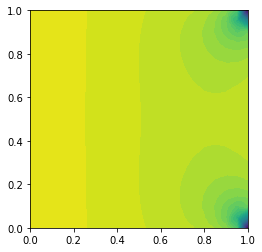

In [11]:
# solve by Shur complement
A_sp = sp.csr_matrix(A.array())
B_sp = sp.csr_matrix(B.array())
BT_sp = sp.csr_matrix(BT.array())

S = B_sp.dot(inv(A_sp).dot(BT_sp))
b = B_sp.dot(inv(A_sp).dot(ff[0:f1.get_local().size])) - ff[f1.get_local().size:nnkns]
x = spsolve(S, b, use_umfpack=True) 

y = inv(A_sp).dot(ff[0:f1.get_local().size] - BT_sp.dot(x))
u = Function(V)
u.vector().set_local(y)

p = Function(Q)
p.vector().set_local(x)
plot(p)

### Method 5: Using cbc.block package (with Python 2 and compatible FEniCS version)

In [12]:
%%capture
!pip install git+https://bitbucket.org/fenics-apps/cbc.block.git
from block import *
from block.dolfin_util import *
from block.iterative import *
from block.algebraic.petsc import *

In [14]:
# 1. mesh generation
n = 20
mesh = UnitSquareMesh(n, n, 'crossed')

# 2. finite element spaces and BCs
V = VectorFunctionSpace(mesh, 'CG', 2)
Q = FunctionSpace(mesh, 'CG', 1)

boundary_markers = MeshFunction('size_t', mesh, mesh.geometric_dimension()-1, 0)

class left_boundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0)

class right_boundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 1)

class other_boundary(SubDomain):
    def inside(self, x, on_boundary):
        bottom_top = near(x[1], 0) or near(x[1], 1)
        return on_boundary and bottom_top

left = left_boundary()
left.mark(boundary_markers, 1)
right = right_boundary()
right.mark(boundary_markers, 2)
other = other_boundary()
other.mark(boundary_markers, 3)
    
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

bcs = [DirichletBC(V, Constant((1, 0)), boundary_markers, 2),
       DirichletBC(V, Constant((0, 0)), boundary_markers, 3)]

# 3. block assembly
u, p = TrialFunction(V), TrialFunction(Q)
v, q = TestFunction(V), TestFunction(Q)

f = Constant((0, 0))
gN = Constant((0, 0))

a = inner(grad(u), grad(v)) * dx
bT = -div(v) * p * dx
b = -div(u) * q * dx
L1 = dot(f, v) * dx + dot(gN, v) * ds
L2 = Constant(0)* q * dx

A, f1 = assemble_system(a, L1)
BT = assemble(bT)
B = assemble(b)
f2 = assemble(L2)
for bc in bcs:
    bc.apply(A, f1)
    bc.zero(BT)

M = assemble(p*q*dx)

ConjGrad NOT CONV. [iter=1000, time=4.44s, res=3.0e-05, true res=6.0e-05]


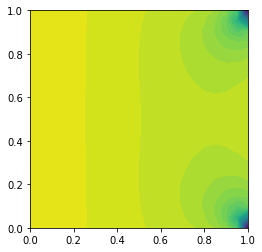

In [15]:
AA = block_mat([[A, BT], [B, 0]])
bb = block_vec([f1, f2])

# Create preconditioner
Ap = AMG(A)
PP = block_mat([[Ap, 0], [0, M]])

# Create the block inverse, using the preconditioned CG method
AAinv = ConjGrad(AA, precond=PP, tolerance=1e-6, maxiter=1000, show=2)

# Compute solution
u, p = AAinv * bb
plot(Function(Q, p))